# Check buoyancy fluxes in easterly simulations

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma0,sigma1

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/Weddell_connectivity/SWMT/'

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35425 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 188.57 GiB


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

start_time='2150-01-01'
end_time='2159-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

lat_slice  = slice(-90,-59)

In [4]:
session_name = '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db'
easterlies_session = cc.database.create_session(session_name)

easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'
easterlies_up_zonal = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'
easterlies_up_meridional = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'

### Shelf masking:

In [5]:
def shelf_mask_isobath(var):
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    # Mask values that are non-zero
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    # Multiply the variable with the mask, we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map

## Control:

In [6]:
# conservative temperature
SST = cc.querying.getvar(control, 'surface_temp', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) - 273.15
SST = SST.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# Practical salinity, need to convert to absolute salinity
SSS_PSU = cc.querying.getvar(control, 'surface_salt', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
SSS_PSU = SSS_PSU.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

# Unfortunately net_sfc_heating diagnostic is incorrect/missing for these runs:
#net_sfc_heating = cc.querying.getvar(control, 'net_sfc_heating', master_session, start_time=start_time, end_time=end_time)
#net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
net_sfc_heating = cc.querying.getvar(control, 'sfc_hflux_from_runoff', master_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(control, 'sfc_hflux_coupler', master_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(control, 'sfc_hflux_pme', master_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(control, 'frazil_3d_int_z', master_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc')
net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

# Mass flux of precipitation - evaporation + river runoff
pme_river = cc.querying.getvar(control, 'pme_river', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
pme_river = pme_river.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# Salt flux from ice and restoring:
salt_flux = cc.querying.getvar(control, 'sfc_salt_flux_ice', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) + \
            cc.querying.getvar(control, 'sfc_salt_flux_restore', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
salt_flux = salt_flux.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

# Coordinates
lon_t = cc.querying.getvar(control,'geolon_t',master_session, n=1)
lon_t = lon_t.sel(yt_ocean=lat_slice)
lat_t = cc.querying.getvar(control,'geolat_t',master_session, n=1)
lat_t = lat_t.sel(yt_ocean=lat_slice)

In [8]:
# limit to continental shelf region:
SST  = shelf_mask_isobath(SST)[0]
SSS_PSU = shelf_mask_isobath(SSS_PSU)[0]
net_sfc_heating = shelf_mask_isobath(net_sfc_heating)[0]
pme_river = shelf_mask_isobath(pme_river)[0]
salt_flux = shelf_mask_isobath(salt_flux)[0]
lon_t   = shelf_mask_isobath(lon_t)[0]
lat_t   = shelf_mask_isobath(lat_t)[0]

In [9]:
# Extract coordinate arrays:
yt_ocean = SST.yt_ocean.values
xt_ocean = SST.xt_ocean.values
time_monthly = SST.time.values

In [10]:
# convert to absolute salinity:

st_ocean = cc.querying.getvar(control,'st_ocean',master_session,n=1)
depth = st_ocean[0].values
depth_tile = (lat_t*0+1)*depth
pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    
# convert units to absolute salinity 
SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})

In [13]:
# Compute salt transformation (no density binning)
haline_contraction  = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
salt_transformation = haline_contraction * SSS * (pme_river - salt_flux)

# Compute heat transformation (no density binning)
thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
c_p = 3992.1
heat_transformation = thermal_expansion * net_sfc_heating / c_p

distributed.nanny - WARNING - Restarting worker


In [14]:
# Compute climatology:

salt_transformation = salt_transformation.groupby("time.month").mean("time")
salt_transformation = salt_transformation.load()

heat_transformation = heat_transformation.groupby("time.month").mean("time")
heat_transformation = heat_transformation.load()

In [16]:
# sum over area:

area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

salt_transformation_sum = (salt_transformation*area_t).sum(dim={'xt_ocean','yt_ocean'}).load()
heat_transformation_sum = (heat_transformation*area_t).sum(dim={'xt_ocean','yt_ocean'}).load()

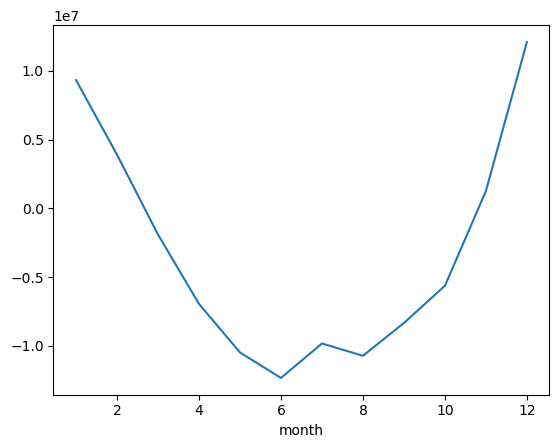

In [18]:
salt_transformation_sum.plot()

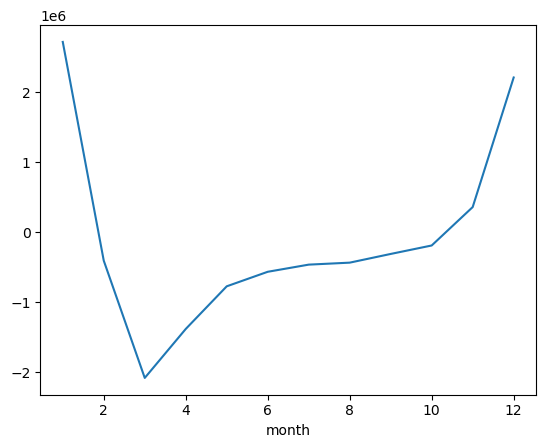

In [19]:
heat_transformation_sum.plot()